# OceanParcels Surface Simmulation Comparison to Rich's Drifters

In [2]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
from datetime import datetime, timedelta
from IPython.display import HTML
from salishsea_tools import nc_tools, places
import scipy.io as spio

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4_3D, AdvectionRK4


%matplotlib inline

In [11]:
# Paths and filenames
drift_file = 'LeaveSoG_20190223T172318.mat'

paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'grid': '/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc',
    'drifters':'/ocean/shared/drifters/data/L3/'+str(drift_file),
    'results': './results',
}

### Functions
#### Drifter Data

In [122]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def datetime_mtopy(datenum):
    '''
    Input
        The fractional day count according to datenum datatype in matlab
    Output
        The date and time as a instance of type datetime in python
    Notes on day counting
        matlab: day one is 1 Jan 0000 
        python: day one is 1 Jan 0001
        hence a reduction of 366 days, for year 0 AD was a leap year
    '''
    ii = datetime.fromordinal(int(datenum) - 366)
    ff = timedelta(days=datenum%1)
    return ii + ff 

#### OceanParcels

In [4]:
def fieldset_from_nemo(daterange, coords, flat=True):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d))
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):
        
        # Exclude vertical velocity if 2D
        if flat:
            if var == 'W': break

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields if 3D (f-points are on W grid)
        if not flat:
            filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
            dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)# field_chunksize='auto')
    
    return field_set

def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

### Load in Drifter Data

In [71]:
drift = loadmat(paths['drifters'])['drift']

['comment',
 'id',
 'design',
 'tzone',
 'mtime',
 'lon',
 'lat',
 'atSea',
 'launchDate',
 'launchDateS',
 'endDate',
 'lifeTime',
 'endsOnLand',
 'foundOnLand',
 'refloated',
 'firstGrndDate',
 'firstLifeTime',
 'deviceid']

In [86]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

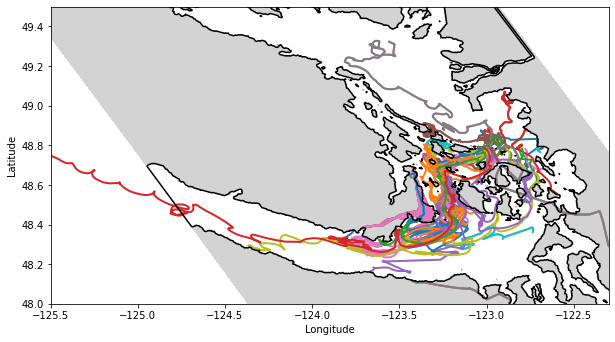

In [40]:
fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')

for i in range(len(drift)):
    s = ax.plot(drift[i].lon,drift[i].lat,label='Drifter '+str(drift[i].id),zorder=1, linewidth ='2')
#plt.legend()

This is toooooooooo many drifters to look at, lets pick a few that we think are interesting

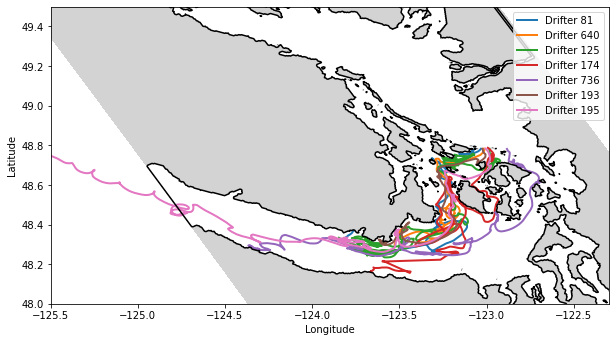

In [69]:
#based on looking at the tracks in groups of 10, i think these ones are worth looking more into
useful = [10,25,26,44,48,52,53]

fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')

for i in useful:
    s = ax.plot(drift[i].lon,drift[i].lat,label='Drifter '+str(drift[i].id),zorder=1, linewidth ='2')
plt.legend()

### Drifter 195

In [124]:
dn=53
print(drift[dn].launchDateS)
print(datetime_mtopy(drift[dn].endDate))

13-Sep-2017 12:11:19
2017-10-01 20:27:34.000004


In [125]:
# Define release parameters
n = 1   # number of particles

# Start time, duration and timestep
start = datetime(2017, 9, 13, 12, 11, 19)
duration = timedelta(days=21) #particel lsot at 66% of the time in
dt = 90#timedelta(seconds=90)

lon, lat = drift[dn].lon[0], drift[dn].lat[0] #places.PLACES[location]['lon lat']
zvals = 2 #m

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [126]:
# Set output file name.  Maybe change for each run
fn = f'with_drifters' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/with_drifters20170913_20171015.nc


In [127]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False) #flat=False forces it to care about bathymetry

In [128]:
# Execute
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-2919/a24fb70e2ce9fa874a9beb98533639e3_0.so
INFO: Temporary output files are stored in ./results/out-DAASAOMT.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-DAASAOMT" to convert these to a NetCDF file during the run.
 66% (1833521.0 of 2764800.0) |######    | Elapsed Time: 0:12:30 ETA:   0:10:15WARNING: ParticleSet is empty on writing as array at time 1.96448e+06
 66% (1836000.0 of 2764800.0) |######    | Elapsed Time: 0:12:30 ETA:   0:07:12

Particle 3 lost !! [-124.92526983875875, 48.672103594757075, 2.0, 1962386.0]


 66% (1837121.0 of 2764800.0) |######    | Elapsed Time: 0:12:31 ETA:   0:10:21WARNING: ParticleSet is empty on writing as array at time 1.96808e+06
 66% (1840721.0 of 2764800.0) |######    | Elapsed Time: 0:12:33 ETA:   0:09:47WARNING: ParticleSet is empty on writing as array at time 1.97168e+06
 66% (1844321.0 of 2764800.0) |######    | Elapsed Time: 0:12:35 ETA:   0:09:52WARNING: ParticleSet is empty on writing as array at time 1.97528e+06
 66% (1847921.0 of 2764800.0) |######    | Elapsed Time: 0:12:36 ETA:   0:10:11WARNING: ParticleSet is empty on writing as array at time 1.97888e+06
 66% (1851521.0 of 2764800.0) |######    | Elapsed Time: 0:12:38 ETA:   0:10:18WARNING: ParticleSet is empty on writing as array at time 1.98248e+06
 67% (1855121.0 of 2764800.0) |######    | Elapsed Time: 0:12:40 ETA:   0:13:20WARNING: ParticleSet is empty on writing as array at time 1.98608e+06
 67% (1858721.0 of 2764800.0) |######    | Elapsed Time: 0:12:41 ETA:   0:13:04WARNING: ParticleSet is emp

In [129]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [130]:
data = xr.open_dataset(outfile)

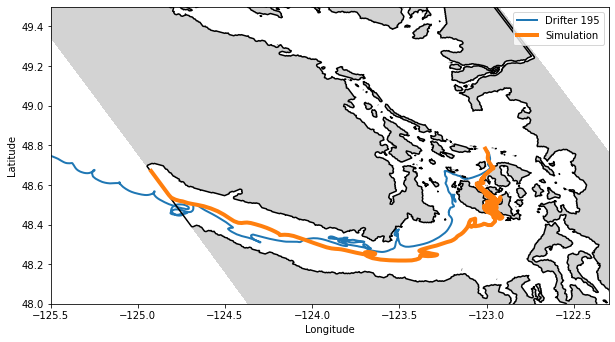

In [131]:
fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')

ax.plot(drift[dn].lon,drift[i].lat,label='Drifter '+str(drift[dn].id),zorder=1, linewidth ='2')

ax.plot(data.lon[0, nmin:nmax], data.lat[0, nmin:nmax], label='Simulation', linewidth='4')

plt.legend()

### Drifter 81

In [157]:
dn=useful[0]
print(drift[dn].launchDateS)
print(datetime_mtopy(drift[dn].endDate))

25-Jul-2016 19:56:32
2016-07-31 00:50:17.000001


In [158]:
# Define release parameters
n = 1   # number of particles

# Start time, duration and timestep
start = datetime(2016, 7, 25, 19, 56, 32)
duration = timedelta(days=6)
dt = 90#timedelta(seconds=90)

lon, lat = drift[dn].lon[0], drift[dn].lat[0] #places.PLACES[location]['lon lat']
print(lon)
print(lat)
zvals = 2 #m

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

-123.03177
48.78262


In [159]:
# Set output file name
fn = f'drifters81_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/drifters81_20160725_20160731.nc


In [160]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False) #flat=False forces it to care about bathymetry

In [161]:
# Execute
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-2919/b0824dc91af26795b206e6ba0e5bea47_0.so
INFO: Temporary output files are stored in ./results/out-MUKGIFWO.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-MUKGIFWO" to convert these to a NetCDF file during the run.
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:03:18 Time:  0:03:18


In [162]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [163]:
data = xr.open_dataset(outfile)

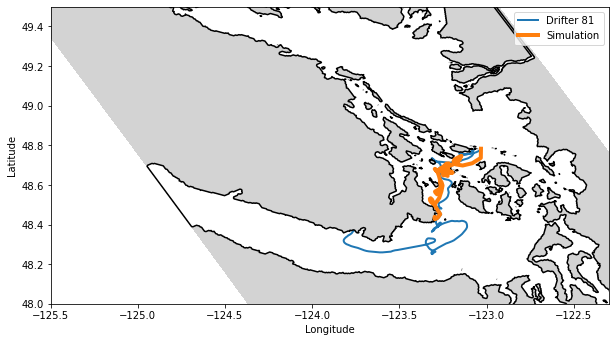

In [164]:
fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')

ax.plot(drift[dn].lon,drift[dn].lat,label='Drifter '+str(drift[dn].id),zorder=1, linewidth ='2')

ax.plot(data.lon[0, nmin:nmax], data.lat[0, nmin:nmax], label='Simulation', linewidth='4')

plt.legend()

### Drifter 640

In [149]:
dn=useful[1]
print(drift[dn].launchDateS)
print(datetime_mtopy(drift[dn].endDate))

11-Apr-2017 13:54:21
2017-04-16 09:01:25.999996


In [150]:
# Define release parameters
n = 1   # number of particles

# Start time, duration and timestep
start = datetime(2017, 4, 11, 13, 54, 21)
duration = timedelta(days=5)
dt = 90#timedelta(seconds=90)

lon, lat = drift[dn].lon[0], drift[dn].lat[0] #places.PLACES[location]['lon lat']
zvals = 2 #m

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [151]:
# Set output file name
fn = f'drifters640_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/drifters640_20170411_20170416.nc


In [152]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False) #flat=False forces it to care about bathymetry

In [153]:
# Execute
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lon, lat=lat, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-2919/049e1e2488486c873ff2c8f670785542_0.so
INFO: Temporary output files are stored in ./results/out-OFMANJNW.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-OFMANJNW" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:02:58 Time:  0:02:58


In [154]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [155]:
data = xr.open_dataset(outfile)

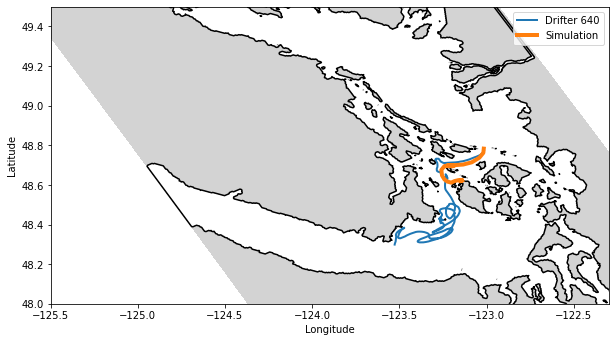

In [156]:
fig, ax = plt.subplots(figsize=(10, 13))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.5, -122.3])
ax.set_ylim([48, 49.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
plt.ylabel('Latitude')
plt.xlabel('Longitude')

ax.plot(drift[dn].lon,drift[dn].lat,label='Drifter '+str(drift[dn].id),zorder=1, linewidth ='2')

ax.plot(data.lon[0, nmin:nmax], data.lat[0, nmin:nmax], label='Simulation', linewidth='4')

plt.legend()